In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
accidents2016 = pd.read_csv("data/CRSS2016CSV/ACCIDENT.csv")
accidents2017 = pd.read_csv("data/CRSS2017CSV/ACCIDENT.csv")
accidents = accidents2016.append(accidents2017, sort=False)

In [3]:
vehicles2016 = pd.read_csv("data/CRSS2016CSV/VEHICLE.csv", low_memory=False)
vehicles2017 = pd.read_csv("data/CRSS2017CSV/VEHICLE.csv", low_memory=False)
vehicles = vehicles2016.append(vehicles2017, sort=False)

In [4]:
persons2016 = pd.read_csv("data/CRSS2016CSV/PERSON.csv")
persons2017 = pd.read_csv("data/CRSS2017CSV/PERSON.csv")
persons = persons2016.append(persons2017, sort=False)

In [5]:
vindecode2016 = pd.read_csv("data/CRSS2016CSV/VINDECODE.csv", low_memory=False)
vindecode2017 = pd.read_csv("data/CRSS2017CSV/VINDECODE.csv", low_memory=False)
vindecode = vindecode2016.append(vindecode2017, sort=False)

In [6]:
overlaping_columns = ['CASENUM', 'REGION', 'PSU', 'PJ', 'PSU_VAR', 'URBANICITY', 'STRATUM', 'VE_FORMS',
                      'MONTH', 'HOUR', 'MINUTE', 'HARM_EV', 'MAN_COLL', 'SCH_BUS', 'PSUSTRAT',
                      'WEIGHT']
df = accidents.merge(persons,  on=overlaping_columns, suffixes=(False, False))

In [7]:
overlaping_columns = ['CASENUM', 'VEH_NO', 'REGION', 'PSU', 'PJ', 'PSU_VAR', 'URBANICITY', 'STRATUM', 'VE_FORMS',
       'MONTH', 'HOUR', 'MINUTE', 'HARM_EV', 'MAN_COLL', 'PSUSTRAT', 'WEIGHT',
       'MAKE', 'BODY_TYP', 'MOD_YEAR', 'MAK_MOD', 'TOW_VEH', 'SPEC_USE',
       'EMER_USE', 'ROLLOVER', 'IMPACT1', 'FIRE_EXP']
df = df.merge(vehicles, on= overlaping_columns,suffixes=(False, False))

In [8]:
overlaping_columns = ["CASENUM", "VEH_NO", "VIN"]
df = df.merge(vindecode, on=overlaping_columns, suffixes=(False, False), how="inner")

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221794 entries, 0 to 221793
Columns: 258 entries, CASENUM to FLAG
dtypes: float64(32), int64(141), object(85)
memory usage: 438.3+ MB


In [356]:
def plot_normalized(data, column_name, aggregate_column = 'MAX_VSEV', sort_by = "Serious or fatal"):
    props = data.groupby(column_name)[aggregate_column].value_counts(normalize=True).unstack()

    props["Serious or fatal"] = props["3 - Serious Injury"] + props["4 - Fatal"]
    props.sort_values(by=sort_by, ascending=False, inplace=True)
    props.drop(columns=["Serious or fatal"], inplace=True)

    g = props.plot(
        kind="bar",
        stacked=True,
        colormap=ListedColormap(sns.color_palette("RdYlGn_r", 5)),
        figsize=(15, 5),
    )
    return g

In [10]:
severety = {
    0: "0 - No Apparent Injury",
    1: "1 - Possible Injury",
    2: "2 - Minor Injury",
    3: "3 - Serious Injury",
    4: "4 - Fatal",
    5: np.nan,
    6: np.nan,
    8: np.nan,
    9: np.nan,
}

In [354]:
from pandas.api.types import CategoricalDtype
 
df.MAX_SEV = df.MAX_SEV.replace(severety)
df.MAX_VSEV = df.MAX_VSEV.replace(severety)
df.INJ_SEV = df.INJ_SEV.replace(severety)

In [12]:
df.MOD_YEAR.replace([9998, 9999], np.nan, inplace=True)

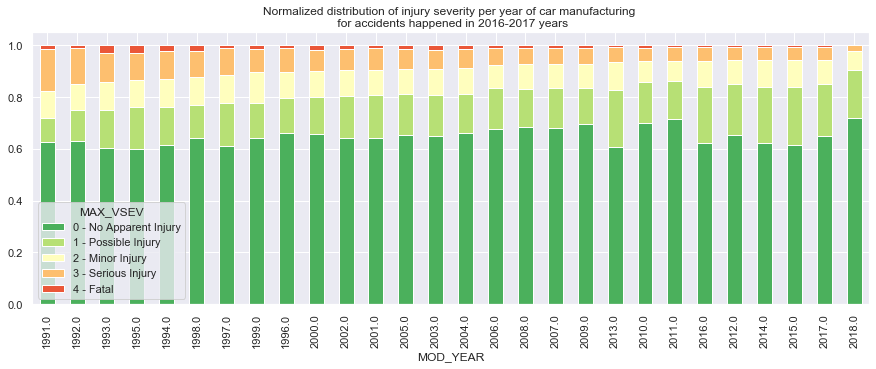

In [301]:
plot_normalized(df[(df.MOD_YEAR > 1990)], "MOD_YEAR")
plt.title(
    "Normalized distribution of injury severity per year of car manufacturing \n for accidents happened in 2016-2017 years"
)
plt.show()

This plot shows normalized distribution of injury severity per year of car manufacturing for accidents happened in 2016-2017 years.
We can clearly see that modern cars provide much better protection for its riders, especially against severe and fatal insures. So the question of whether to upgrade the car is not only about convenience but also about safety. 

In [14]:
threshold = 300
vc = df["BODYSTYL_T"].value_counts()
vals_to_remove = vc[vc <= threshold].index.values
df["BODYSTYL_T"].loc[df["BODYSTYL_T"].isin(vals_to_remove)] = np.nan

C:\Users\Aleks\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


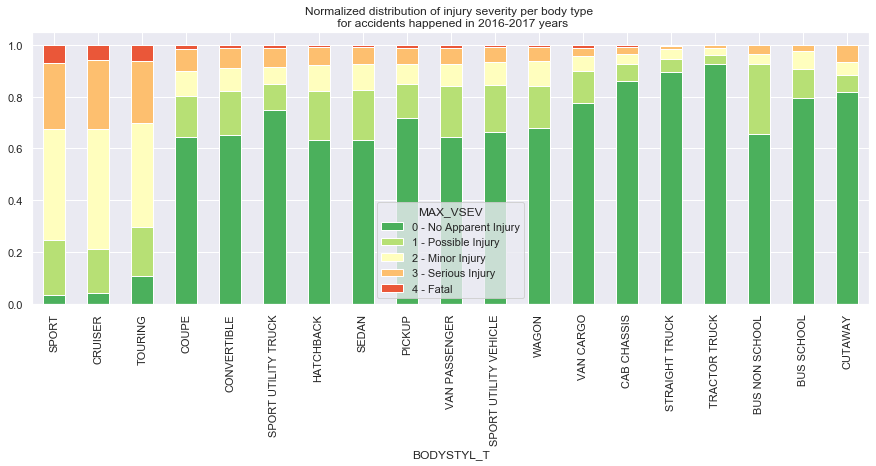

In [302]:
plot_normalized(df, "BODYSTYL_T")
plt.title(
    "Normalized distribution of injury severity per body type \n for accidents happened in 2016-2017 years"
)
plt.show()

This plot shows the normalized distribution of injury severity per body type for accidents happened in 2016-2017 years. 
Different vehicle body types strongly impact the severity of the injury if a crash happened. 
For motorcycles, if crash happened, there is almost no chance not to receive any injury, while for any car your chances are about 45-70%.
Most safe is school buses, followed by straight trucks. Weight of the vehicle matters a lot!
The most popular car types - sedans and SUV shows very similar distributions, while I personally thought that SUV's are much safer. They are, but not that much. 
Cutaways show unusually large fatal rate. 

Coupes provide you with better protection against light injuries, but the fatal rate is worse. 


In [58]:
from scipy import stats

In [80]:
stats.chi2_contingency(props[props.index.isin(["TOURING", "CRUISER"])])

(22.24421171569731,
 0.00017918797890931602,
 4,
 array([[ 30.70757984, 127.25663717, 325.61100423, 191.43824548,
          43.98653328],
        [ 80.29242016, 332.74336283, 851.38899577, 500.56175452,
         115.01346672]]))

In [81]:
stats.chi2_contingency(props[props.index.isin(["SEDAN", "HATCHBACK"])])

(2.2975228716125615,
 0.6812200917194318,
 4,
 array([[ 3689.59879048,  2118.77245085,  1193.83514124,   798.14574926,
           120.64786817],
        [37748.40120952, 21677.22754915, 12214.16485876,  8165.85425074,
          1234.35213183]]))

In [75]:
a = [[10,10,10],[1000,1000,1000]]
stats.chi2_contingency(a)

(0.0, 1.0, 2, array([[  10.,   10.,   10.],
        [1000., 1000., 1000.]]))

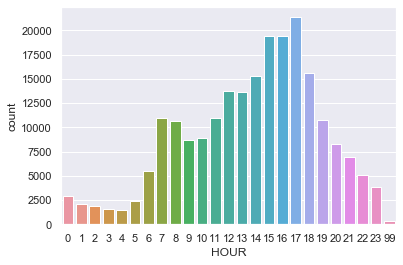

In [84]:
sns.countplot(df.HOUR)

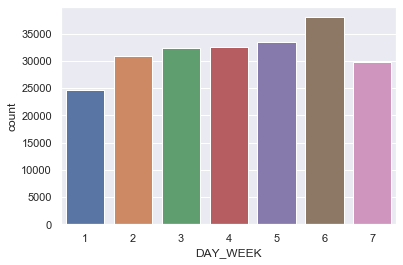

In [85]:
sns.countplot(df.DAY_WEEK)

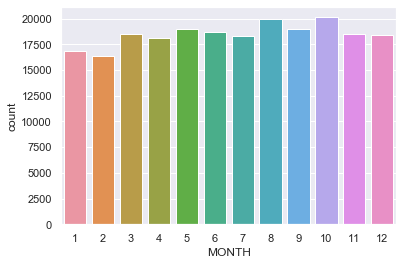

In [246]:
sns.countplot(df.MONTH)

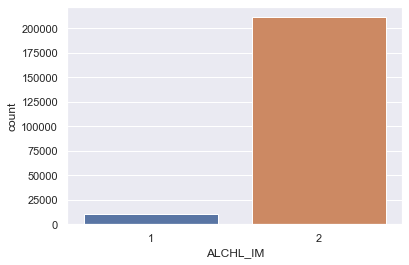

In [90]:
sns.countplot(df.ALCHL_IM)

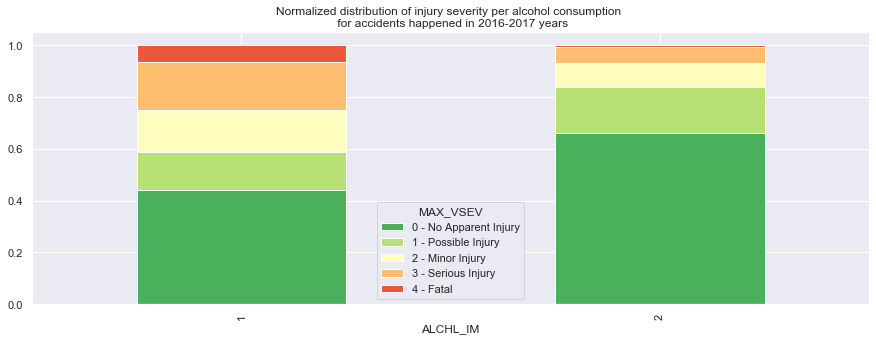

In [306]:
plot_normalized(df, "ALCHL_IM")
plt.title(
    "Normalized distribution of injury severity per alcohol consumption \n for accidents happened in 2016-2017 years"
)
plt.show()

In [200]:
makers_dict = {
    2: "Jeep",
    6: "Chrysler",
    7: "Dodge",
    12: "Ford",
    18: "Buick",
    20: "Chevrolet",
    22: "Pontiac",
    23: "GMC",
    30: "Volkswagen",
    34: "BMW",
    35: "Nissan",
    37: "Honda",
    41: "Mazda",
    42: "Mercedes-Benz",
    48: "Subaru",
    49: "Toyota",
    55: "Hyundai",
    59: "Lexus",
    63: "Kia",
    19: "Cadillac",
    54: "Acura",
    52: "Mitsubishi",
    82: "Freightliner/White",
    58: "Infiniti",
    72: "Harley-Davidson",
    14: "Mercury",
    24: "Saturn",
    51: "Volvo",
    13: "Lincoln",
    98: "Other Make",
    53: "Suzuki",
    84: "International Harvester/Navistar",
    99: np.nan,
}

df.MAKE = df.MAKE.replace(makers_dict)

major_manufactors = (df.MAKE.value_counts(normalize=True)>0.006).reset_index()
major_manufactors = major_manufactors[major_manufactors['MAKE'] == True]['index'].tolist()

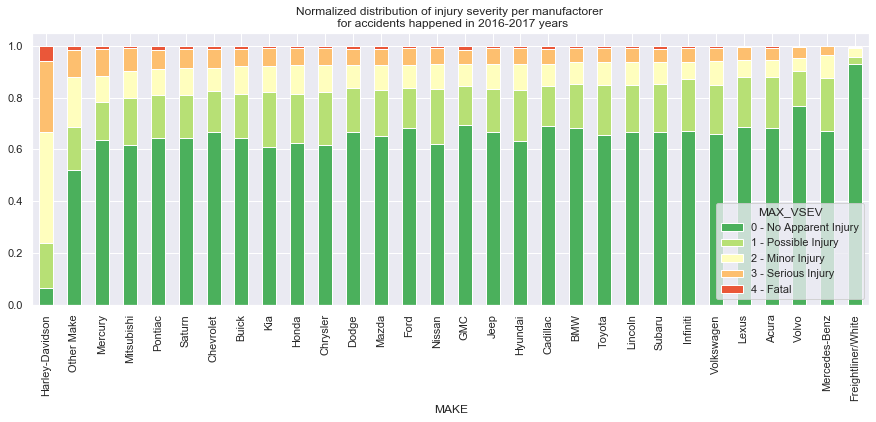

In [304]:
plot_normalized(df[df.MAKE.isin(major_manufactors)], "MAKE")
plt.title(
    "Normalized distribution of injury severity per manufactorer \n for accidents happened in 2016-2017 years"
)
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

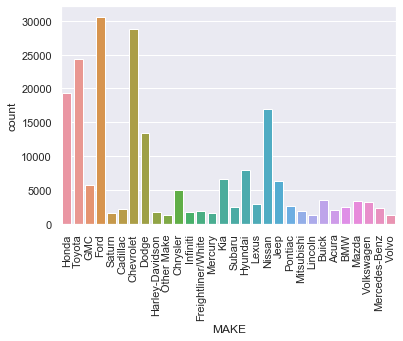

In [238]:
sns.countplot(df[df.MAKE.isin(major_manufactors)].MAKE)
plt.xticks(rotation=90)

In [250]:
P_CRASH3_dict = {
    0: "No Driver Present/Unknown if Driver Present",
    1: "No Avoidance Maneuver",
    5: "Releasing Brakes",
    6: "Steering Left",
    7: "Steering Right",
    8: "Braking And Steering Left",
    9: "Braking And Steering Right",
    10: "Accelerated",
    11: "Accelerating And Steering Left",
    12: "Accelerating And Steering Right",
    15: "Braking and Unknown Steering Direction",
    16: "Braking",
    98: np.nan,
    99: np.nan,
}
df.P_CRASH3 = df.P_CRASH3.replace(P_CRASH3_dict)

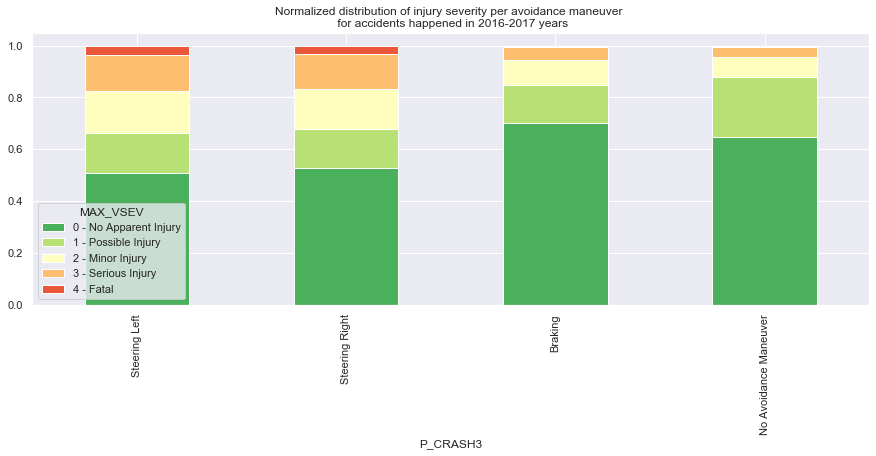

In [305]:
data = df[df.P_CRASH3.isin(["No Avoidance Maneuver", "Steering Left", "Steering Right", "Braking"])]

plot_normalized(data, "P_CRASH3")
plt.title(
    "Normalized distribution of injury severity per avoidance maneuver \n for accidents happened in 2016-2017 years"
)
plt.show()

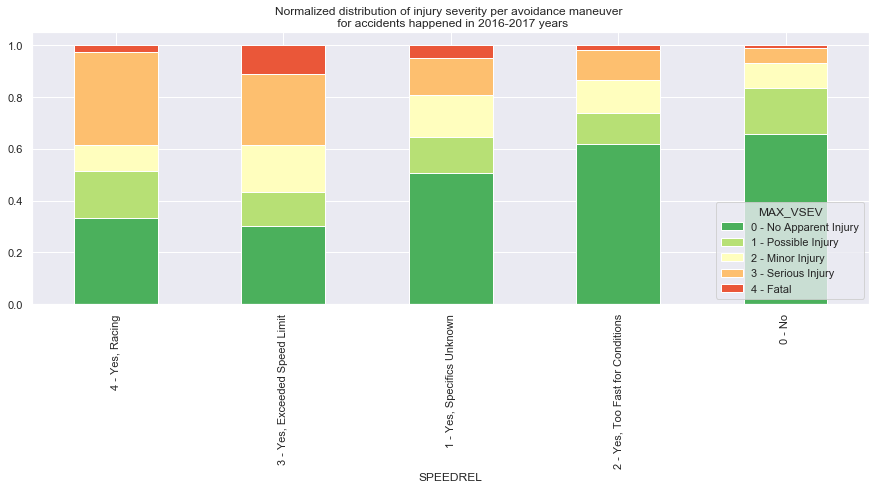

In [313]:
plot_normalized(df, "SPEEDREL")
plt.title(
    "Normalized distribution of injury severity per avoidance maneuver \n for accidents happened in 2016-2017 years"
)
plt.show()

In [312]:
SPEEDREL_dict = {
    0: '0 - No',
    2: '3 - Yes, Racing',
    3: '2 - Yes, Exceeded Speed Limit',
    4: '1 - Yes, Too Fast for Conditions',
    5: np.nan,
    8: np.nan,
    9: np.nan,
}
df.SPEEDREL = df.SPEEDREL.replace(SPEEDREL_dict)

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

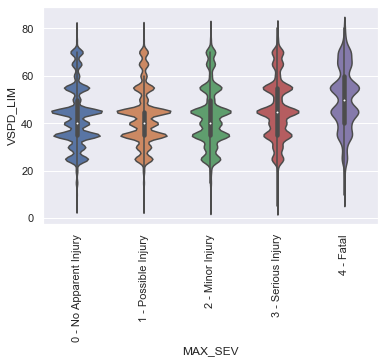

In [340]:
sns.violinplot(
    y="VSPD_LIM",
    x="MAX_SEV",
    order=[
        "0 - No Apparent Injury",
        "1 - Possible Injury",
        "2 - Minor Injury",
        "3 - Serious Injury",
        "4 - Fatal",
    ],
    data=df[(df["VSPD_LIM"] > 0) & (df["VSPD_LIM"] < 97)],
)

plt.xticks(rotation=90)

In [358]:
REST_USE_dict = {
    0: np.nan,
    1: "Belt Used",
    2: "Belt Used",
    3: "Belt Used",
    4: "Child Restraint Type Unknown",
    5: "Helmet",
    7: "None Used",
    8: "Belt Used",
    10: "Child Restraint System – Forward Facing",
    11: "Child Restraint System – Rear Facing",
    12: "Booster Seat",
    16: "Helmet",
    17: "No Helmet",
    19: "Helmet",
    20: "None Used",
    29: np.nan,
    96: np.nan,
    97: np.nan,
    98: np.nan,
    99: np.nan,
}
df.REST_USE = df.REST_USE.replace(REST_USE_dict)

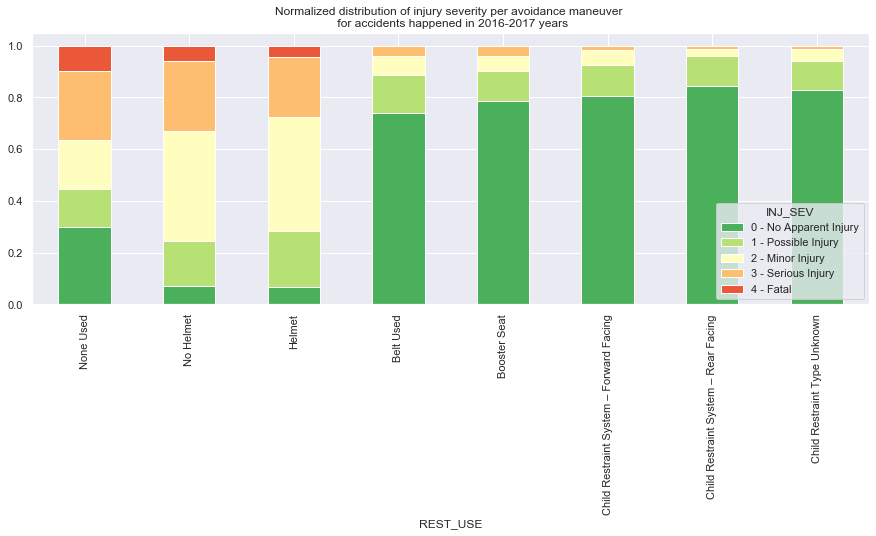

In [359]:
plot_normalized(df, column_name = "REST_USE", aggregate_column = 'INJ_SEV')
plt.title(
    "Normalized distribution of injury severity per avoidance maneuver \n for accidents happened in 2016-2017 years"
)
plt.show()

In [368]:
SEAT_POS_dict = {
    11: "Front Seat – Driver’s Side)",
    12: "Front Seat – Middle",
    13: "Front Seat – Right Side",
    21: "Second Seat – Left Side",
    22: "Second Seat – Middle",
    23: "Second Seat – Right Side",
    31: "Third Seat – Left Side",
    32: "Third Seat – Middle",
    33: "Third Seat – Right Side",
    98: np.nan,
    51: np.nan,
    18: np.nan,
    99: np.nan,
    52: np.nan,
    28: np.nan,
    50: np.nan,
    19: np.nan,
    53: np.nan,
    38: np.nan,
    29: np.nan,
    55: np.nan,
    41: np.nan,
    39: np.nan,
    49: np.nan,
    42: np.nan,
    43: np.nan,
    54: np.nan,
}
df.SEAT_POS = df.SEAT_POS.replace(SEAT_POS_dict)

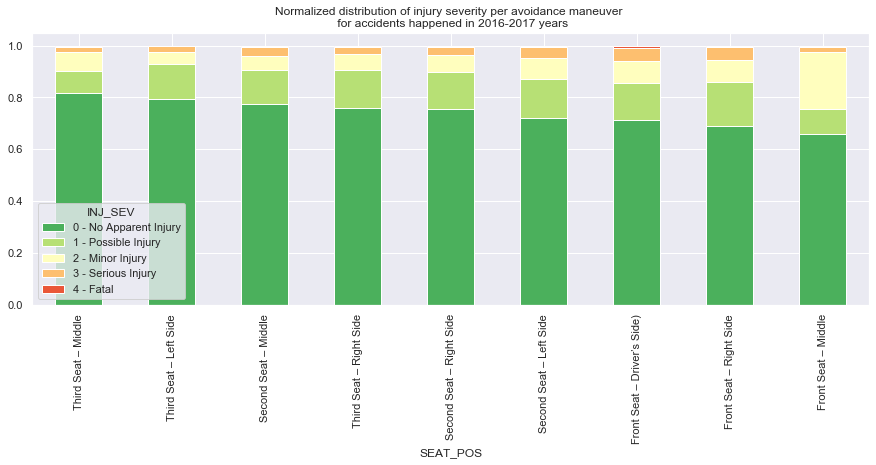

In [371]:
plot_normalized(df, column_name = "SEAT_POS", aggregate_column = 'INJ_SEV', sort_by = "0 - No Apparent Injury")
plt.title(
    "Normalized distribution of injury severity per avoidance maneuver \n for accidents happened in 2016-2017 years"
)
plt.show()